In [1]:
%reload_ext cairo_jupyter

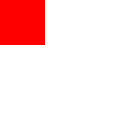

In [50]:
import cairo

from contextlib import contextmanager
from io import BytesIO
from pathlib import Path

from IPython.display import display

FORMAT_PS = 'ps'
FORMAT_PDF = 'pdf'
FORMAT_PNG = 'png'
FORMAT_SVG = 'svg'
FORMAT_SVG_XML = 'svg_xml'

VALID_FORMATS = [FORMAT_PNG, FORMAT_SVG, FORMAT_SVG_XML]

ERROR_UNSUPPORTED_FORMAT = "Format must be FORMAT_PDF, FORMAT_PNG, FORMAT_PS, FORMAT_SVG or FORMAT_SVG_XML"

class BufferedCanvas:
    """
    Uses a RecordingSurface to keep track of the draw state on the current frame/page,
    and allowing it to be copied to various outputs as needed.
    """
    def __init__(self, extents=None):
        """
        :param dimensions: Extents of recording surface, or None for unbounded.
        """
        self.surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents) 
    
    def copy_to_surface(self, surface):
        # Draw self.surface onto another surface
        ctx = cairo.Context(surface)
        ctx.set_source_surface(self.surface)
        ctx.paint()
        del ctx

    def save(self, f, format=None, *args, **kwargs):
        """
        Output current canvas frame, using cairo to save.
        
        :param f: buffer or filename.
        """
        if not format:
            if isinstance(f, str):
                suffix = Path(f).suffix
                format = suffix.rsplit('.')[-1] or FORMAT_PNG
            else:
                format = FORMAT_PNG
        
        extents = self.surface.ink_extents()  # TODO: handle ink_extents that don't start at 0, 0
        dimensions = extents[2], extents[3]
        if format == FORMAT_PNG:
            # PNG is special: write_to_png is called after drawing.
            surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, int(dimensions[0]), int(dimensions[1]))
            self.copy_to_surface(surface)
            surface.write_to_png(f)
            return
        elif format == FORMAT_PDF:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format == FORMAT_PS:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format in (FORMAT_SVG, FORMAT_SVG_XML):
            surface = cairo.SVGSurface(f, *dimensions)
        else:
            raise ValueError(ERROR_UNSUPPORTED_FORMAT)
            
        self.copy_to_surface(surface)
        surface.flush()  # Ensure data written to file or buffer.

    def display(self, format=None, *args, **kwargs):
        """
        """
        from IPython.display import Image, SVG, display as _display

        if format in (FORMAT_PDF, FORMAT_PS):
            raise NotImplementedError(f"{format} is not yet supported.")
        
        if format is None:
            if not args and self.surface.ink_extents() == (.0, .0, .0, .0):
                format = FORMAT_SVG  # 0 size images are legal in SVG.
            else:
                format = FORMAT_PNG
        
        with BytesIO() as buffer:
            self.save(buffer, format, *args)
            if format == FORMAT_PNG:
                _display(Image(data=buffer.getvalue()))
            elif format == FORMAT_SVG:
                _display(SVG(buffer.getvalue()))
            elif format == FORMAT_SVG_XML:
                try:
                    from display_xml import XML
                except ImportError:
                    raise ImportError('Install display_xml to output as XML:  $ pip3 install display_xml')

                _display(XML(buffer.getvalue()))
            else:
                # Included for completeness, should have been caught by the call to save().
                raise ValueError(ERROR_UNSUPPORTED_FORMAT)
    
    @contextmanager
    def recording_surface(self, extents=None):
        _surface = self.surface
        self.surface = surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents)
        try:
            yield surface
        except:
            self.surface = _surface
            raise
        
        # No exceptions were raised, draw
        cr = cairo.Context(_surface)
        cr.set_source_surface(surface)
        cr.paint()
        
        self.surface = _surface

      
class AnimationState:
    def __init__(self, speed = None):
        self.speed = speed
    
    def is_animation(self):
        return self.speed is None

class ShoebotContext:
    def __init__(self, canvas, ns=None):
        if ns is not None:
            self._ns = {}
        else:
            self._ns = ns
            
        self._canvas = canvas
        self._fillcolor = (1., 0., 0.)
            
    def rect(self, x, y, w, h):
        ctx = cairo.Context(self._canvas.surface)
        ctx.set_source_rgb(*self._fillcolor)
        ctx.rectangle(x, y, x+w, y+h)
        ctx.fill()
        
def context_as_dict(context):
    return {name: getattr(context, name) for name in dir(context) if not name.startswith('_')}
        

class ShoebotRunner:
    def __init__(self, **kwargs):
        self.canvas = BufferedCanvas(**kwargs)
        self.context = ShoebotContext(self.canvas)
    
    def run_once(self, code):
        # TODO: During first frame canvas is already cleared.
                
        # TODO: During subsequent frames if canvas should be
        # cleared use show_page, otherwise copy_page  for outputs.
        with self.canvas.recording_surface() as surface:
            _vars = dict(context_as_dict(self.context))
            exec(code, _vars, _vars)
    
    def run_multiple(self, code):
        pass
    
    def run(self, code):
        self.run_once(code)

# # Draw on surface
# canvas = BufferedCanvas()
# ctx = cairo.Context(canvas.surface)
# ctx.set_source_rgb(.5, .5, 1.)
# ctx.rectangle(10, 10, 90, 90)
# ctx.fill()

# # intermediate ImageSurface 1
# print("ImageSurface")
# canvas.display(format=FORMAT_PNG, dimensions=(128, 128))

# # intermediate SVGSurface to buffer
# print("SVG to buffer")
# canvas.display(format=FORMAT_SVG)
# canvas.display(format=FORMAT_SVG_XML)


# # continue drawing
# print("continue drawing...")
# ctx.set_source_rgb(1., .5, .5)
# ctx.rectangle(100, 10, 90, 90)
# ctx.fill()

# del ctx

# print("Display final surface")

# canvas.surface.ink_extents()

# print("Canvas display as bitmap")
# canvas.display(FORMAT_PNG, dimensions=(180, 40))

# print("Canvas display svg")
# canvas.display(FORMAT_SVG)

code = """\
import cairo

#int("oops")

#ctx = cairo.Context(surface)
#ctx.set_source_rgb(1., .5, .1)
#ctx.translate(65, 65)
#ctx.rotate(.7)
#ctx.rectangle(-50, -50, 100, 100)
#ctx.fill()

rect(0, 0, 45, 45)

"""

runner = ShoebotRunner(extents=(0, 0, 128, 128))

# Draw on surface
canvas = runner.canvas
# ctx = cairo.Context(canvas.surface)
# ctx.set_source_rgb(.5, .5, 1.)
# ctx.rectangle(10, 10, 90, 90)
# ctx.fill()

#print(canvas.surface.ink_extents())



runner.run(code)
runner.canvas.display()

In [32]:
import inspect

dir(runner.context)

#runner.context.__dict__.keys()

{name: getattr(runner.context, name) for name in dir(runner.context) if not name.startswith('_')}

{'cairo': <module 'cairo' from '/home/stu/.virtualenvs/shoebot/lib/python3.8/site-packages/cairo/__init__.py'>,
 'rect': <bound method ShoebotContext.rect of <__main__.ShoebotContext object at 0x7ff699ebc520>>}